# Data Modeling

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.ensemble import RandomForestRegressor

In [4]:
# Directories for the data
linear_reg = r'../data/processed_data/linear_regression_data.csv'
decision_tree = r'../data/processed_data/decision_tree_data.csv'
random_forest = r'../data/processed_data/random_forest_data.csv'

In [5]:
linear_regression_preprocessed_data = pd.read_csv(linear_reg)
decision_tree_preprocessed_data = pd.read_csv(decision_tree)
random_forest_preprocessed_data = pd.read_csv(random_forest)

## Linear Regression

In [7]:
# Features: Select the relevant columns to use as features
features = [
    'Corn_Acres_Planted', 'Soybean_Acres_Planted', 'Corn_Cash_Receipts',
    'Corn_Production_Bushels', 'Corn_Production_Dollars', 'Corn_Yield_Bushels',
    'Soybean_Cash_Receipts', 'Soybean_Production_Bushels', 'Soybean_Production_Dollars',
    'Soybean_Yield_Bushels'
]

In [8]:
# List of target variables for the three models
targets = ['Employment_Rural', 'Personal_Income_Rural', 'Poverty_Levels']

In [9]:
# Dictionary to store the R² and RMSE for each model
model_results = {}

In [10]:
# Loop through each target and set up a linear regression model
for target in targets:
    # Drop rows with missing values in the selected features and current target
    data_cleaned = linear_regression_preprocessed_data.dropna(subset=features + [target])
    
    # Defining X (features) and y (target)
    X = data_cleaned[features]
    y = data_cleaned[target]
    
    # Splitting the data into training and testing sets (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Initialize and train the Linear Regression model
    linear_model = LinearRegression()
    linear_model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = linear_model.predict(X_test)
    
    # Store actual and predicted values separately for each target
    if target == 'Employment_Rural':
        y_test_empl = y_test
        y_pred_empl = y_pred
    elif target == 'Personal_Income_Rural':
        y_test_income = y_test
        y_pred_income = y_pred
    elif target == 'Poverty_Levels':
        y_test_poverty = y_test
        y_pred_poverty = y_pred

    # Evaluate the model: R² score and Root Mean Squared Error (RMSE)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    # Store the results in the dictionary
    model_results[target] = {'R2': r2, 'RMSE': rmse}

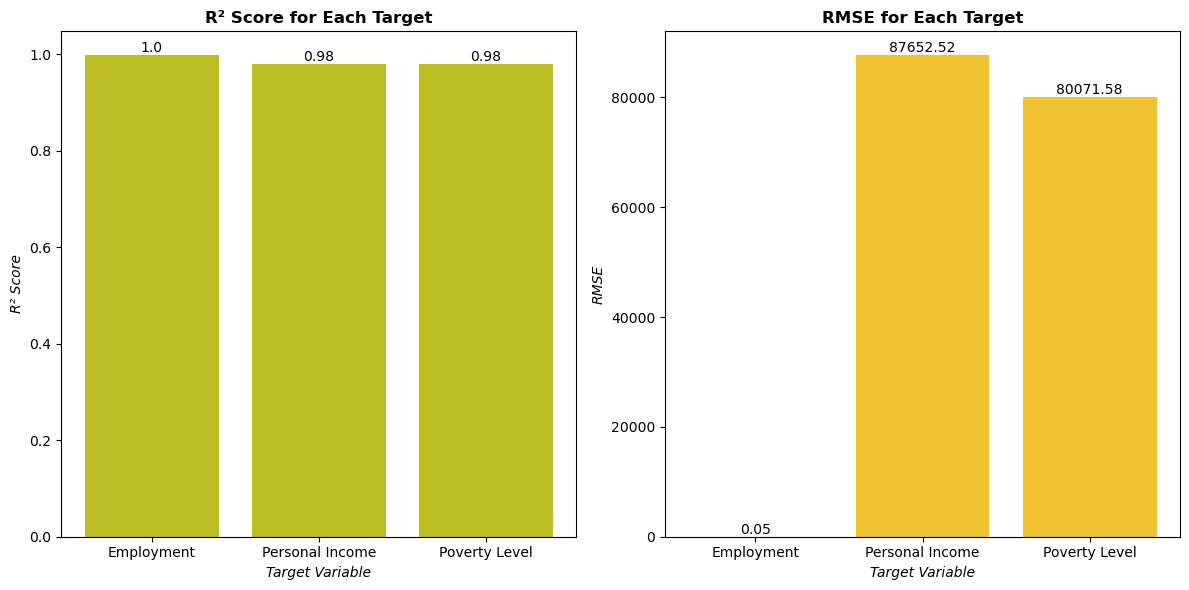

In [11]:
# Now let's visualize the R² and RMSE for each model
targets_labels = ['Employment', 'Personal Income', 'Poverty Level']
r2_scores = [model_results[t]['R2'] for t in targets]
rmse_scores = [model_results[t]['RMSE'] for t in targets]

# Creating a new figure with two bar plots for R² and RMSE, adding data labels, bold titles, and italic axis labels
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot R² scores (bar plot)
bars1 = ax1.bar(targets_labels, r2_scores, color='tab:olive')
ax1.set_title('R² Score for Each Target', fontweight='bold')
ax1.set_xlabel('Target Variable', fontstyle='italic')
ax1.set_ylabel('R² Score', fontstyle='italic')

# Add data labels to R² bars (rounded to two decimal points)
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom', ha='center')

# Plot RMSE scores (bar plot)
bars2 = ax2.bar(targets_labels, rmse_scores, color='#f1c232')
ax2.set_title('RMSE for Each Target', fontweight='bold')
ax2.set_xlabel('Target Variable', fontstyle='italic')
ax2.set_ylabel('RMSE', fontstyle='italic')

# Add data labels to RMSE bars (rounded to two decimal points)
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom', ha='center')

# Adjust layout for a cleaner look
plt.tight_layout()
# Define the path to save the plots
plots_directory = '../plots/'
plt.savefig(plots_directory + 'linear_reg_results.png')
plt.show()

### Interpretation

1. **R² Score for Each Target (Left Plot)**

Employment, Personal Income, all show very strong fit and strong predictive power. However, employment shows signs of overfitting with the model explaining 100% of the variance in the employmetn data.

2. **RMSE for Each Target (Right Plot)**

Employment has an RMSE score of 0.05, which means that the model’s predictions for employment are very close to the actual values. The error is minimal.

Personal Income: The RMSE is 87,652.52. Considering that the mean value of personal income is 1,184,693, this error is about 7.4% of the average income. Given the high variability in personal income (standard deviation: $2,004,435), this is an acceptable RMSE. The model performs reasonably well, though there is still room for improvement.

Poverty Levels: The RMSE is 80,071.58, and the mean poverty level is 1,192,697, meaning the RMSE is around 6.7% of the mean poverty level. Similarly, this is a good result relative to the high variability in the poverty level data (standard deviation: 2,037,935). Like the personal income model, this RMSE suggests the model is performing well given the variability.

## Decision Tree

In [14]:
# Features: Select the relevant columns to use as features
features = [
    'Corn_Acres_Planted', 'Soybean_Acres_Planted', 'Corn_Cash_Receipts',
    'Corn_Production_Bushels', 'Corn_Production_Dollars', 'Corn_Yield_Bushels',
    'Soybean_Cash_Receipts', 'Soybean_Production_Bushels', 'Soybean_Production_Dollars',
    'Soybean_Yield_Bushels'
]

In [15]:
# List of target variables for the three models
targets = ['Employment_Rural', 'Personal_Income_Rural', 'Poverty_Levels']

In [16]:
# Define the hyperparameter grid for grid search
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

In [17]:
# Initialize the Decision Tree model
decision_tree = DecisionTreeRegressor(random_state=42)

In [18]:
# Initialize dictionary to store the best results for each model
decision_tree_results = {}

In [19]:
# Loop through each target and perform grid search with cross-validation
for target in targets:
    # Drop rows with missing values in the selected features and current target
    data_cleaned = decision_tree_preprocessed_data.dropna(subset=features + [target])
    
    # Defining X (features) and y (target)
    X = data_cleaned[features]
    y = data_cleaned[target]
    
    # Splitting the data into training and testing sets (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Initialize GridSearchCV with cross-validation
    grid_search = GridSearchCV(estimator=decision_tree, param_grid=param_grid, 
                               cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    
    # Fit the model using Grid Search
    grid_search.fit(X_train, y_train)
    
    # Get the best parameters and refit the model using those parameters
    best_model = grid_search.best_estimator_
    
    # Make predictions on the test set
    y_pred = best_model.predict(X_test)
    
    # Evaluate the model: R² score and Root Mean Squared Error (RMSE)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    # Store the best parameters and evaluation metrics
    decision_tree_results[target] = {
        'Best Parameters': grid_search.best_params_,
        'R2': r2,
        'RMSE': rmse
    }

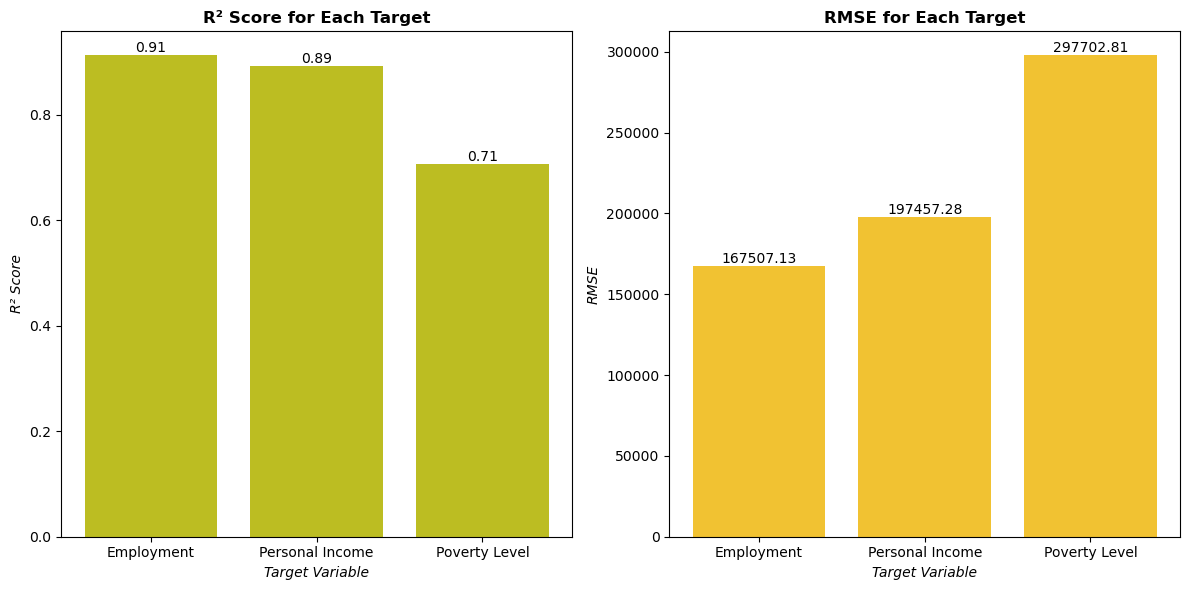

In [20]:
# Now let's visualize the R² and RMSE for each decision tree model
targets_labels = ['Employment', 'Personal Income', 'Poverty Level']
decision_tree_r2_scores = [decision_tree_results[t]['R2'] for t in targets]
decision_tree_rmse_scores = [decision_tree_results[t]['RMSE'] for t in targets]

# Creating a new figure with two bar plots for R² and RMSE for the decision tree models
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot R² scores (bar plot)
bars1 = ax1.bar(targets_labels, decision_tree_r2_scores, color='tab:olive')
ax1.set_title('R² Score for Each Target', fontweight='bold')
ax1.set_xlabel('Target Variable', fontstyle='italic')
ax1.set_ylabel('R² Score', fontstyle='italic')

# Add data labels to R² bars (rounded to two decimal points)
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom', ha='center')

# Plot RMSE scores (bar plot)
bars2 = ax2.bar(targets_labels, decision_tree_rmse_scores, color='#f1c232')
ax2.set_title('RMSE for Each Target', fontweight='bold')
ax2.set_xlabel('Target Variable', fontstyle='italic')
ax2.set_ylabel('RMSE', fontstyle='italic')

# Add data labels to RMSE bars (rounded to two decimal points)
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom', ha='center')

# Adjust layout for a cleaner look
plt.tight_layout()
plt.savefig(plots_directory + 'decision_tree_results.png')
plt.show()

In [21]:
# Output the best hyperparameters and metrics for each target
for target in targets:
    print(f"\nBest parameters for {target}: {decision_tree_results[target]['Best Parameters']}")
    print(f"R² Score for {target}: {decision_tree_results[target]['R2']}")
    print(f"RMSE for {target}: {decision_tree_results[target]['RMSE']}")


Best parameters for Employment_Rural: {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
R² Score for Employment_Rural: 0.9130106875039217
RMSE for Employment_Rural: 167507.13394691914

Best parameters for Personal_Income_Rural: {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
R² Score for Personal_Income_Rural: 0.8921619609819741
RMSE for Personal_Income_Rural: 197457.28446876246

Best parameters for Poverty_Levels: {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
R² Score for Poverty_Levels: 0.7074148034885721
RMSE for Poverty_Levels: 297702.8071171726


### Interpretation

1. **R² Score for Each Target (Left Plot)**

Performs well for employment and personal income, by having 91% of the variance in employment explained and 89% of the variance in personal income explained using the decision tree model. However, this model struggled with capturing important relationships in the poverty level data with only 71% of the variance being explained.

2. **RMSE for Each Target (Right Plot)**

For employment, the RMSE of 167,507 compared to the mean employment value (around 1,184,693) suggests the model's predictions have an average error of around 14% of the mean (1,184,693).
For personal income, the RMSE is approximately 16% of the mean personal of value.
For poverty levels, the RMSE is approximately 25% of the mean poverty level (1,192,697). Which is a substantial error, indicating the model struggled to predict poverty levels accurately, which is a consistent with the lower R² score of 0.71 for this target variable.

**How it Compares to Linear Regression Model**

The Decision Tree model performed worse than the Linear Regression model. It's accuracy was lower than the Linear Regression model; it was able to capture general patterns in the data but made larger prediction errors.

# Random Forest

In [24]:
# Features: Select the relevant columns to use as features
features = [
    'Corn_Acres_Planted', 'Soybean_Acres_Planted', 'Corn_Cash_Receipts',
    'Corn_Production_Bushels', 'Corn_Production_Dollars', 'Corn_Yield_Bushels',
    'Soybean_Cash_Receipts', 'Soybean_Production_Bushels', 'Soybean_Production_Dollars',
    'Soybean_Yield_Bushels'
]

In [25]:
# List of target variables for the three models
targets = ['Employment_Rural', 'Personal_Income_Rural', 'Poverty_Levels']

In [26]:
# Define the corrected hyperparameter grid for grid search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]  # Corrected this line
}

In [27]:
# Initialize the Random Forest model
random_forest = RandomForestRegressor(random_state=42)

In [28]:
# Initialize dictionary to store the best results for each model
random_forest_results = {}

In [29]:
# Loop through each target and perform grid search with cross-validation
for target in targets:
    # Drop rows with missing values in the selected features and current target
    data_cleaned = random_forest_preprocessed_data.dropna(subset=features + [target])
    
    # Defining X (features) and y (target)
    X = data_cleaned[features]
    y = data_cleaned[target]
    
    # Splitting the data into training and testing sets (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Initialize GridSearchCV with cross-validation
    grid_search = GridSearchCV(estimator=random_forest, param_grid=param_grid, 
                               cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    
    # Fit the model using Grid Search
    grid_search.fit(X_train, y_train)
    
    # Get the best parameters and refit the model using those parameters
    best_model = grid_search.best_estimator_
    
    # Make predictions on the test set
    y_pred = best_model.predict(X_test)
    
    # Evaluate the model: R² score and Root Mean Squared Error (RMSE)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    # Store the best parameters and evaluation metrics
    random_forest_results[target] = {
        'Best Parameters': grid_search.best_params_,
        'R2': r2,
        'RMSE': rmse
    }

C:\Users\deeps\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


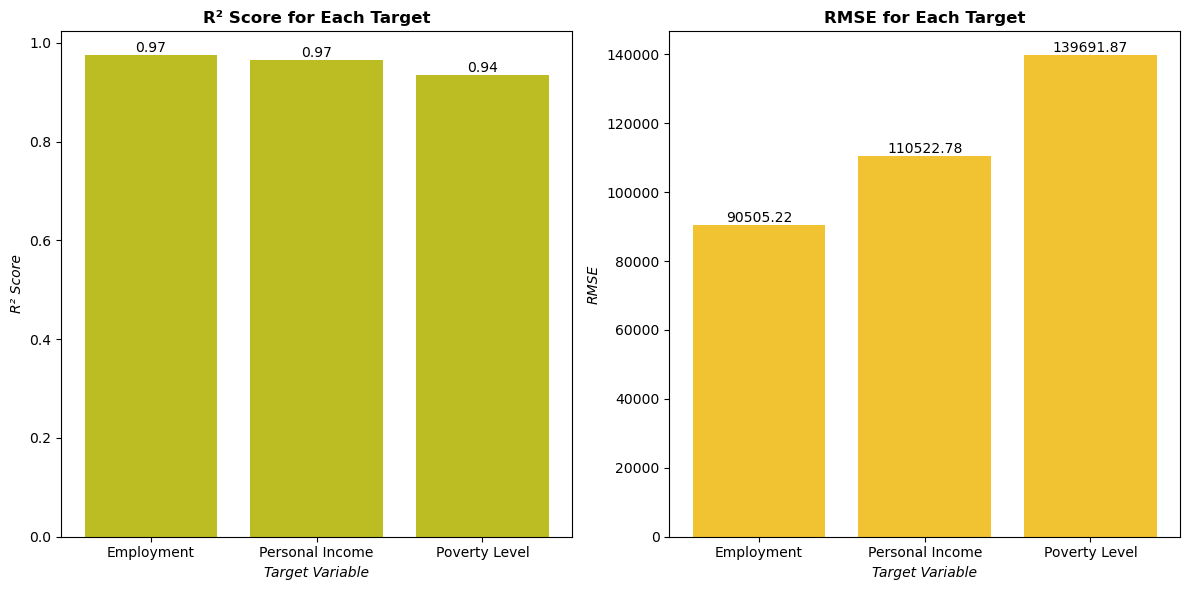

In [30]:
# Now let's visualize the R² and RMSE for each random forest model
targets_labels = ['Employment', 'Personal Income', 'Poverty Level']
random_forest_r2_scores = [random_forest_results[t]['R2'] for t in targets]
random_forest_rmse_scores = [random_forest_results[t]['RMSE'] for t in targets]

# Creating a new figure with two bar plots for R² and RMSE for the random forest models
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot R² scores (bar plot)
bars1 = ax1.bar(targets_labels, random_forest_r2_scores, color='tab:olive')
ax1.set_title('R² Score for Each Target', fontweight='bold')
ax1.set_xlabel('Target Variable', fontstyle='italic')
ax1.set_ylabel('R² Score', fontstyle='italic')

# Add data labels to R² bars (rounded to two decimal points)
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom', ha='center')

# Plot RMSE scores (bar plot)
bars2 = ax2.bar(targets_labels, random_forest_rmse_scores, color='#f1c232')
ax2.set_title('RMSE for Each Target', fontweight='bold')
ax2.set_xlabel('Target Variable', fontstyle='italic')
ax2.set_ylabel('RMSE', fontstyle='italic')

# Add data labels to RMSE bars (rounded to two decimal points)
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom', ha='center')

# Adjust layout for a cleaner look
plt.tight_layout()
plt.savefig(plots_directory + 'random_forest_results.png')
plt.show()

In [31]:
# Output the best hyperparameters and metrics for each target
for target in targets:
    print(f"\nBest parameters for {target}: {random_forest_results[target]['Best Parameters']}")
    print(f"R² Score for {target}: {random_forest_results[target]['R2']}")
    print(f"RMSE for {target}: {random_forest_results[target]['RMSE']}")


Best parameters for Employment_Rural: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
R² Score for Employment_Rural: 0.9746050968651284
RMSE for Employment_Rural: 90505.22220120332

Best parameters for Personal_Income_Rural: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
R² Score for Personal_Income_Rural: 0.9662145819554496
RMSE for Personal_Income_Rural: 110522.7844333036

Best parameters for Poverty_Levels: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
R² Score for Poverty_Levels: 0.9355788101420485
RMSE for Poverty_Levels: 139691.86842487493


### Interpretation

1. **R² Score for Each Target (Left Plot)**

Performed well across all three target variables, capturing 94 to 97% of the variance. 

2. **RMSE for Each Target (Right Plot)**

For employment, the RMSE of 90,505.22 means the average prediction error for employment is relatively low.
For personal income, the RMSE is about 9% of the mean 1,184,693.
For poverty levels, The RMSE is 139,691.87, indicating the average prediction error.

**How it Compares to Linear Regression and Decision Tree Models**

Overall, the Random Forest model performed better than the Decision Tree model, but not as good as the Linear Regression model. 

## Best Model: Linear Regression

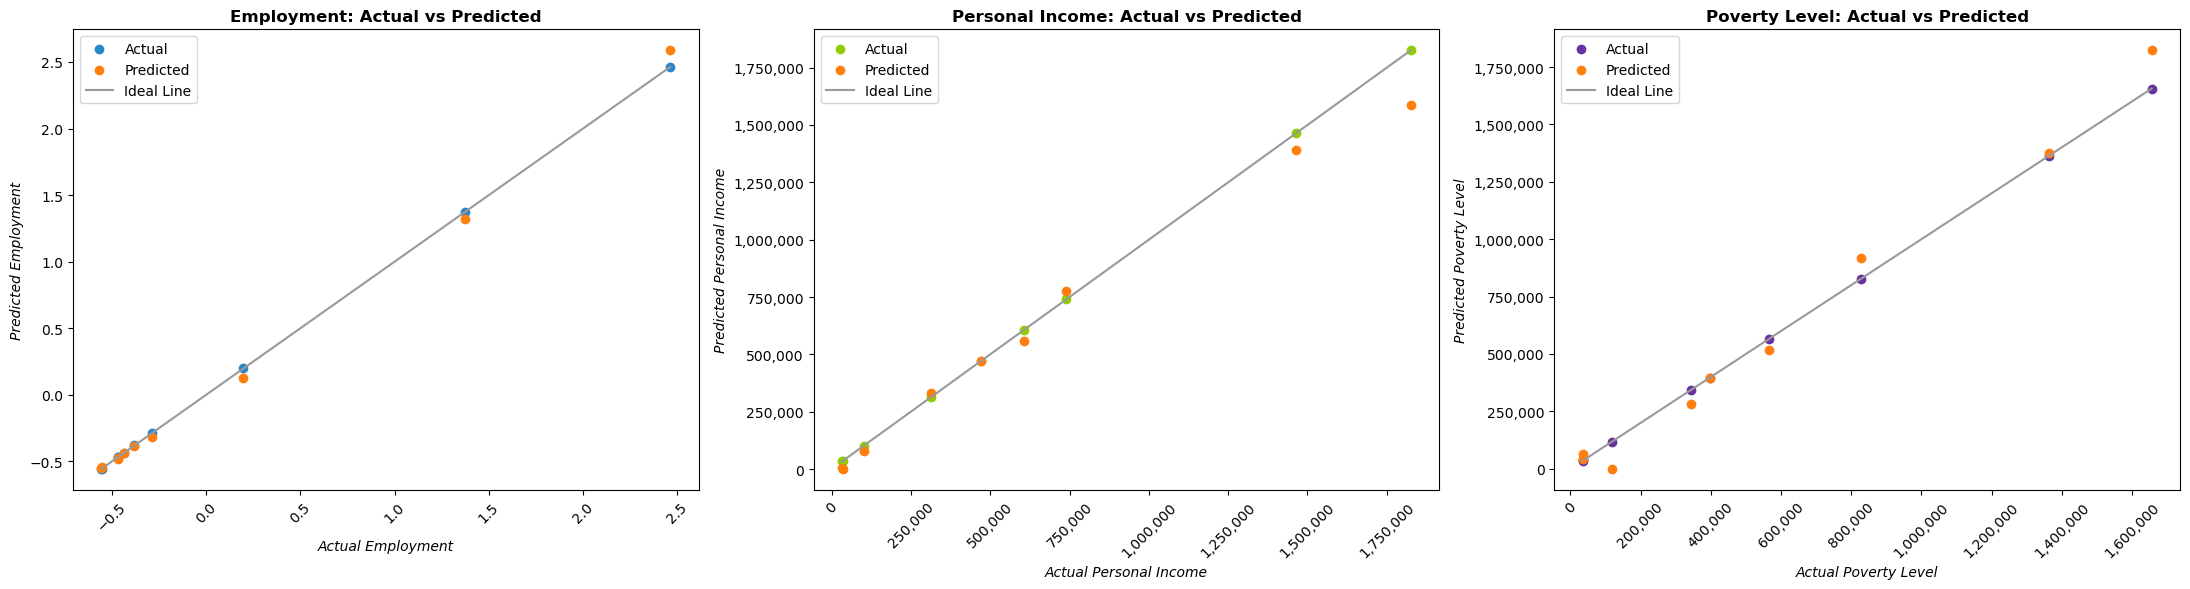

In [34]:
# Create subplots for the three targets
fig, axes = plt.subplots(1, 3, figsize=(22, 6))

# Employment: Actual vs Predicted
axes[0].scatter(y_test_empl, y_test_empl, color='#2986cc', label='Actual')
axes[0].scatter(y_test_empl, y_pred_empl, color='#ff7f0e', label='Predicted')
axes[0].plot([min(y_test_empl), max(y_test_empl)], [min(y_test_empl), max(y_test_empl)], color='#999999', label='Ideal Line')
axes[0].set_title('Employment: Actual vs Predicted', fontweight='bold')
axes[0].set_xlabel('Actual Employment', fontstyle='italic')
axes[0].set_ylabel('Predicted Employment', fontstyle='italic')
axes[0].legend()
axes[0].tick_params(axis='x', rotation=45)  # Rotate x-axis labels for Employment

# Personal Income: Actual vs Predicted
axes[1].scatter(y_test_income, y_test_income, color='#8fce00', label='Actual')
axes[1].scatter(y_test_income, y_pred_income, color='#ff7f0e', label='Predicted')
axes[1].plot([min(y_test_income), max(y_test_income)], [min(y_test_income), max(y_test_income)], color='#999999', label='Ideal Line')
axes[1].set_title('Personal Income: Actual vs Predicted', fontweight='bold')
axes[1].set_xlabel('Actual Personal Income', fontstyle='italic')
axes[1].set_ylabel('Predicted Personal Income', fontstyle='italic')

# Turn off scientific notation for Personal Income
axes[1].get_yaxis().set_major_formatter(mticker.FuncFormatter(lambda x, p: format(int(x), ',')))
axes[1].get_xaxis().set_major_formatter(mticker.FuncFormatter(lambda x, p: format(int(x), ',')))
axes[1].legend()
axes[1].tick_params(axis='x', rotation=45)  # Rotate x-axis labels for Personal Income

# Poverty Level: Actual vs Predicted
axes[2].scatter(y_test_poverty, y_test_poverty, color='#6a329f', label='Actual')
axes[2].scatter(y_test_poverty, y_pred_poverty, color='#ff7f0e', label='Predicted')
axes[2].plot([min(y_test_poverty), max(y_test_poverty)], [min(y_test_poverty), max(y_test_poverty)], color='#999999', label='Ideal Line')
axes[2].set_title('Poverty Level: Actual vs Predicted', fontweight='bold')
axes[2].set_xlabel('Actual Poverty Level', fontstyle='italic')
axes[2].set_ylabel('Predicted Poverty Level', fontstyle='italic')

# Turn off scientific notation for Poverty Levels
axes[2].get_yaxis().set_major_formatter(mticker.FuncFormatter(lambda x, p: format(int(x), ',')))
axes[2].get_xaxis().set_major_formatter(mticker.FuncFormatter(lambda x, p: format(int(x), ',')))
axes[2].legend()
axes[2].tick_params(axis='x', rotation=45)  # Rotate x-axis labels for Poverty Levels

# Adjust layout for cleaner appearance
plt.tight_layout()
plt.savefig(plots_directory + 'actual_vs_predicted_separate_dots.png')
plt.show()

## Interpretation

**Reading the plots**
Blue, Green, or Purple Dots: Represent the actual values.
Orange Dots: Represent the predicted values made by the model.
Ideal Line (Gray): This line represents the scenario where the predicted values exactly match the actual values (i.e., y_test = y_pred). Ideally, points should lie on or near this line if the model is performing well.

**Interpretation for Each Plot**

Employment: Actual vs Predicted (Left Plot):

Most of the predicted values (orange dots) are very close to the actual values (blue dots), with some minor deviations.
The predicted and actual values align well with the ideal line, suggesting the model is performing well for this target.
However, for values between 0 and 1.5, the orange dots overlap almost completely with the actual values, indicating high prediction accuracy in this range.

Personal Income: Actual vs Predicted (Middle Plot):

There is a good match between the actual (green) and predicted (orange) values, especially for values below 1,000,000.
For larger values, especially around 1,750,000, the predicted values slightly deviate from the actual ones, indicating some error in high-value predictions.
Overall, the predictions align well with the ideal line, meaning the model performs well for most of the personal income data but struggles slightly with higher values.

Poverty Level: Actual vs Predicted (Right Plot):

The predicted values (orange) show more deviation from the actual values (purple) compared to the other two targets.
There is a noticeable gap between the predicted and actual values in the higher range (1,000,000 to 1,600,000), indicating some significant prediction errors for the highest poverty levels.
While the general trend is captured (as seen by the alignment with the ideal line), the deviations suggest that the model may struggle to accurately predict extreme poverty level values.